# Generative Augmentation

This notebook demonstrates the different augmentation techniques discussed in the paper

In [1]:
import argparse
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from torchvision.utils import save_image
from util import *
from PIL import Image
import math
import random
import os
import glob

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm

from model import *
from e4e_projection import projection as e4e_projection

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


from copy import deepcopy

try:
    import wandb

except ImportError:
    wandb = None

In [2]:
def get_latent(paths, device=None):

    """
    Given list of images projects each image into styleGANs latent space using PSP
    :param 
        paths:  list of images
    :return
        imgs: torch array of the inpit images
        latents: torch array of latent codes
    """
    transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    )
    if type(paths) == list(): paths = [paths]
    
    imgs, latents = [], []
    for path in paths:
        assert os.path.exists(path), f"{path} does not exist!"
            
        img = Image.open(path).convert('RGB')
        
        latent = e4e_projection(img, device=device)
        imgs.append(transform(img))
        latents.append(latent)
    
    latents = torch.stack(latents, 0).squeeze(1).to(device)
    imgs = torch.stack(imgs, 0).to(device)
    
    return imgs, latents

In [3]:
def finetune_StyleGAN(original_generator, discriminator, styleA_img, latents):

    alpha =  0

    preserve_color = False
    num_iter = 300

    # del generatorA, generatorB, trans_func
    # to be finetuned generator
    generator = deepcopy(original_generator)
    
    optimizer = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

    # Which layers to swap for generating a family of plausible real images -> fake image
    if preserve_color:
        id_swap = [9,11,15,16,17]
    else:
        id_swap = list(range(7, original_generator.n_latent))

    # remove the comment if wanting to randomize the face image for the pair
    if latents == None:
        latents = generator.get_latent(
            torch.randn([latents.size(0), latents.size(1), latent_dim]).to(device))

    pbar = tqdm(range(num_iter))
    for idx in pbar:
        # Sample a random w from styleGAN latent space
        rand_w = original_generator.get_latent(
            torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, original_generator.n_latent, 1)
        # Clone the W+ of StyleA obtained from PSP
        in_latent = latents.clone()

        # Replace the last layers of in_latent+ with transformed rand_w
        in_latent[:, id_swap] = alpha*in_latent[:, id_swap] + (1-alpha)*rand_w[:, id_swap]

        # Generate styleA
        gen_imgA = generator(in_latent, input_is_latent=True)

        # Obtain the features for the discriminator
        with torch.no_grad():
            real_feat_A = discriminator(styleA_img)
        fake_feat_A = discriminator(gen_imgA)

        # # Compute L1 feature loss of (realA, genA) and (realB, genB)
        loss_disc_A = sum([F.l1_loss(a, b) for a, b in zip(real_feat_A, fake_feat_A)])/len(fake_feat_A)

        loss = loss_disc_A

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
        
        pbar.set_description(
            (f" loss_disc_A: {loss_disc_A.item():.4f};")
            )
    return generator

Load the stleGAN generator for different domains, if not saved trained finetune styleGAN for different domains

In [4]:
def load_generators(original_generator, discriminator, model_A_path='models/stylegan2-pencil_sketch.pt', model_B_path='models/stylegan2-water_color.pt', model_C_path='models/stylegan2-color_sketch.pt'):
    """
    Given list of images projects each image into styleGANs latent space using PSP
    :param 
        paths:  list of images
    :return
        imgs: torch array of the inpit images
        latents: torch array of latent codes
    """
    if os.path.exists(model_A_path):
        print(f'Loaded {model_A_path}')
        ckpt = torch.load(model_A_path, map_location=lambda storage, loc: storage)
        generatorA = deepcopy(original_generator)
        generatorA.load_state_dict(ckpt["g_ema"], strict=False)
    else:
        imgs = ['data/style_ref/celebA_ref/sketch_147.jpg'] # Ref image of domain A
        sketch_ref, sketch_w = get_latent(imgs, device)
        generatorA = finetune_StyleGAN(original_generator, discriminator, sketch_ref, sketch_w)
        torch.save({"g_ema": generatorA.state_dict()}, model_A_path)

    if os.path.exists(model_B_path):
        print(f'Loaded {model_B_path}')
        ckpt = torch.load(model_B_path, map_location=lambda storage, loc: storage)
        generatorB = deepcopy(original_generator)
        generatorB.load_state_dict(ckpt["g_ema"], strict=False)
    else:
        imgs = ['data/style_ref/watercolor_147.jpg'] # Ref image of domain B
        toon_ref, toon_w = get_latent(imgs, device)
        generatorB = finetune_StyleGAN(original_generator, discriminator, toon_ref, toon_w)
        torch.save({"g_ema": generatorB.state_dict()}, model_B_path)


    if os.path.exists(model_C_path):
        print(f'Loaded {model_C_path}')
        ckpt = torch.load(model_C_path, map_location=lambda storage, loc: storage)
        generatorC = deepcopy(original_generator)
        generatorC.load_state_dict(ckpt["g_ema"], strict=False)
    else:
        imgs = ['data/style_ref/celebA_ref/color_sketch147.jpg'] # Ref image of domain C   
        toon_ref, toon_w = get_latent(imgs, device)
        generatorC = finetune_StyleGAN(original_generator, discriminator, toon_ref, toon_w)
        torch.save({"g_ema": generatorC.state_dict()}, model_C_path)

    return generatorA, generatorB, generatorC

In [5]:
device = 'cuda'
    
iteration=1000 #"total training iterations"
batch_size=1 #"No of pairs each training iteration"
size=1024 #"image sizes for the model"
latent_dim=512 #"StyleGAN latent code dim"

StyleGAN_ckpt='models/stylegan2-ffhq-config-f.pt' #"path to the checkpoints to resume training",

In [6]:
# Load original generator
original_generator = Generator(size, latent_dim, 8).to(device)
ckpt = torch.load(StyleGAN_ckpt, map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# load discriminator for perceptual loss
discriminator = Discriminator(size).eval().to(device)
ckpt = torch.load(StyleGAN_ckpt, map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)
discriminator.eval()
print("Loaded generator and discriminator")

Loaded generator and discriminator


In [7]:
generatorA, generatorB, generatorC = load_generators(original_generator, discriminator)

Loaded models/stylegan2-pencil_sketch.pt
Loaded models/stylegan2-water_color.pt
Loaded models/stylegan2-color_sketch.pt


## Evaluate the loaded generators

In [8]:
test_samples = 1

z = torch.randn(test_samples, latent_dim, device=device)

with torch.no_grad():
    generatorA.eval()
    generatorB.eval()
    generatorC.eval()

    true_img = original_generator([z], input_is_latent=False)
    # Generate styleA and styleB
    gen_imgA = generatorA([z], input_is_latent=False)
    gen_imgB = generatorB([z], input_is_latent=False)
    gen_imgC = generatorC([z], input_is_latent=False)

/home/kowshik/anaconda3/envs/pytorch_new/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


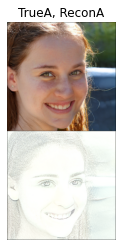

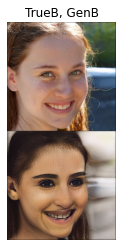

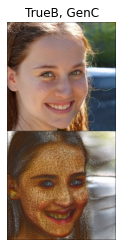

In [9]:
recon_A = torch.cat([true_img, gen_imgA], 0)
recon_A = utils.make_grid(recon_A, normalize=True, range=(-1, 1), nrow=test_samples)
display_image(recon_A, title='TrueA, ReconA')

recon_B = torch.cat([true_img, gen_imgB], 0)
recon_B = utils.make_grid(recon_B, normalize=True, range=(-1, 1), nrow=test_samples)
display_image(recon_B, title='TrueB, GenB')

recon_C = torch.cat([true_img, gen_imgC], 0)
recon_C = utils.make_grid(recon_C, normalize=True, range=(-1, 1), nrow=test_samples)
display_image(recon_C, title='TrueB, GenC')

## Generate target data

In [10]:
def generate_data(original_generator, generatorA, generatorB, generatorC, num_samples = 10000):

    # data_dir = 'data/multi_domain_interpol_gen'
    data_dir = 'datasets/GAN/multi_domain_interpol_gen_10K'
    

    os.makedirs(f'{data_dir}/orig/', exist_ok=True)
    os.makedirs(f'{data_dir}/z/', exist_ok=True)

    os.makedirs(f'{data_dir}/pencil_sketch/', exist_ok=True)
    os.makedirs(f'{data_dir}/colorsketch/', exist_ok=True)
    os.makedirs(f'{data_dir}/watercolor/', exist_ok=True)

    for i in tqdm(range(num_samples)):
        # Sample a random z from styleGAN latent space
        z = torch.randn(1, latent_dim, device=device)
        # z = torch.load(f'{data_dir}/z/{i}.pt')

        with torch.no_grad():
            orig_img = original_generator([z], input_is_latent=False)
            orig_img = utils.make_grid(orig_img[0], normalize=True, range=(-1, 1))
            save_image(orig_img, f'{data_dir}/orig/{i}.png')


            dom_A = generatorA([z], input_is_latent=False)
            dom_A = utils.make_grid(dom_A[0], normalize=True, range=(-1, 1))
            save_image(dom_A, f'{data_dir}/pencil_sketch/{i}.png')


            dom_B = generatorB([z], input_is_latent=False)
            dom_B = utils.make_grid(dom_B[0], normalize=True, range=(-1, 1))
            save_image(dom_B, f'{data_dir}/watercolor/{i}.png')

            dom_C = generatorC([z], input_is_latent=False)
            dom_C = utils.make_grid(dom_C[0], normalize=True, range=(-1, 1))
            save_image(dom_C, f'{data_dir}/colorsketch/{i}.png')
            torch.save(z, f'{data_dir}/z/{i}.pt')

In [ ]:
generate_data(original_generator, generatorA, generatorB, generatorC, num_samples=1000)

## Pruning Zero

In [12]:
test_samples = 1

z = torch.randn(test_samples, latent_dim, device=device)

with torch.no_grad():
    generatorA.eval()
    generatorB.eval()

    true_img = original_generator([z], input_is_latent=False)
    true_img_zero = original_generator([z], input_is_latent=False, percentile=50, mask_type='zeros')
    # Generate styleA and styleB
    gen_imgA_zeros = generatorA([z], input_is_latent=False, percentile=50, mask_type='zeros')
    gen_imgB_zeros = generatorB([z], input_is_latent=False, percentile=50, mask_type='zeros')
    
    gen_imgA = generatorA([z], input_is_latent=False)
    gen_imgB = generatorB([z], input_is_latent=False)
    gen_imgC = generatorC([z], input_is_latent=False)

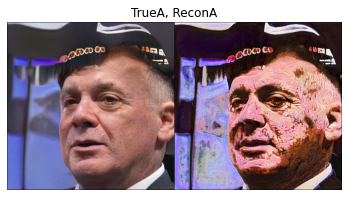

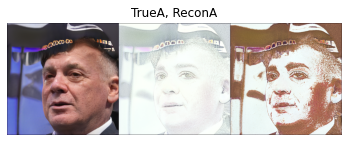

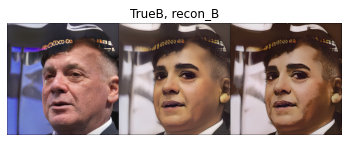

In [13]:
recon_T = torch.cat([true_img, true_img_zero], 0)
recon_T = utils.make_grid(recon_T, normalize=True, range=(-1, 1), nrow=recon_T.shape[0])
display_image(recon_T, title='TrueA, ReconA')
save_image(recon_T, 'activation_edit_T.png')

recon_A = torch.cat([true_img, gen_imgA, gen_imgA_zeros], 0)
recon_A = utils.make_grid(recon_A, normalize=True, range=(-1, 1), nrow=recon_A.shape[0])
display_image(recon_A, title='TrueA, ReconA')
save_image(recon_A, 'activation_edit_A.png')

recon_B = torch.cat([true_img, gen_imgB, gen_imgB_zeros], 0)
recon_B = utils.make_grid(recon_B, normalize=True, range=(-1, 1), nrow=recon_B.shape[0])
display_image(recon_B, title='TrueB, recon_B')
save_image(recon_B, 'activation_edit_B.png')

In [14]:
def generate_data_activation_prune_pairs(original_generator, generatorA, generatorB, generatorC):

    # data_dir = 'data/multi_domain_interpol_gen'
    data_dir = 'datasets/GAN/multi_domain_interpol_gen_10K'
    
    os.makedirs(f'{data_dir}/orig/', exist_ok=True)
    os.makedirs(f'{data_dir}/z/', exist_ok=True)
    for i in tqdm(range(10000)):
        if os.path.exists(f'{data_dir}/z/{i}.pt'):
            z = torch.load(f'{data_dir}/z/{i}.pt')
        else:
            # Sample a random z from styleGAN latent space
            # z = torch.randn(1, latent_dim, device=device)
            continue

        with torch.no_grad():
            for j in range(1):
                # Generate styleA and styleB
                img_styleA = generatorA([z], input_is_latent=False, percentile=50, mask_type='zeros')
                img_styleB = generatorB([z], input_is_latent=False, percentile=50, mask_type='zeros')
                img_styleC = generatorC([z], input_is_latent=False, percentile=50, mask_type='zeros')
                
                os.makedirs(f'{data_dir}/prune_0_pencil_sketch_{j}/', exist_ok=True)
                os.makedirs(f'{data_dir}/prune_0_colorsketch_{j}/', exist_ok=True)
                os.makedirs(f'{data_dir}/prune_0_watercolor_{j}/', exist_ok=True)
                
                img_styleA = utils.make_grid(img_styleA[0], normalize=True, range=(-1, 1))
                img_styleB = utils.make_grid(img_styleB[0], normalize=True, range=(-1, 1))
                img_styleC = utils.make_grid(img_styleC[0], normalize=True, range=(-1, 1))

                
                save_image(img_styleA, f'{data_dir}/prune_0_pencil_sketch_{j}/{i}.png')
                save_image(img_styleB, f'{data_dir}/prune_0_watercolor_{j}/{i}.png')
                save_image(img_styleC, f'{data_dir}/prune_0_colorsketch_{j}/{i}.png')

In [ ]:
generate_data_activation_prune_pairs(original_generator, generatorA, generatorB, generatorC)

## Pruning Rewind

In [15]:
def generate_data_activation_prune_random_pairs(original_generator, generatorA, generatorB, generatorC):

    # data_dir = 'data/multi_domain_interpol_gen'
    data_dir = 'datasets/GAN/multi_domain_interpol_gen_10k'
    

    os.makedirs(f'{data_dir}/orig/', exist_ok=True)
    os.makedirs(f'{data_dir}/z/', exist_ok=True)
    for i in tqdm(range(1000)):
        if os.path.exists(f'{data_dir}/z/{i}.pt'):
            z = torch.load(f'{data_dir}/z/{i}.pt')
        else:
            # Sample a random z from styleGAN latent space
            # z = torch.randn(1, latent_dim, device=device)
            continue

        with torch.no_grad():
            # Generate styleA and styleB
            orig_img, orig_activations = original_generator([z], input_is_latent=False, mask_type='rewind')
            
            img_styleA = generatorA([z], input_is_latent=False, percentile=20, mask_type='rewind', orig_activations=orig_activations)
            img_styleB = generatorB([z], input_is_latent=False, percentile=20, mask_type='rewind', orig_activations=orig_activations)
            img_styleC = generatorC([z], input_is_latent=False, percentile=20, mask_type='rewind', orig_activations=orig_activations)
            
            os.makedirs(f'{data_dir}/prune_rewind_pencil_sketch_20/', exist_ok=True)
            os.makedirs(f'{data_dir}/prune_rewind_colorsketch_20/', exist_ok=True)
            os.makedirs(f'{data_dir}/prune_rewind_watercolor_20/', exist_ok=True)
            
            img_styleA = utils.make_grid(img_styleA[0], n1ormalize=True, range=(-1, 1))
            img_styleB = utils.make_grid(img_styleB[0], normalize=True, range=(-1, 1))
            img_styleC = utils.make_grid(img_styleC[0], normalize=True, range=(-1, 1))

            save_image(img_styleA, f'{data_dir}/prune_rewind_pencil_sketch_50/{i}.png')
            save_image(img_styleB, f'{data_dir}/prune_rewind_watercolor_50/{i}.png')
            save_image(img_styleC, f'{data_dir}/prune_rewind_colorsketch_50/{i}.png')

In [ ]:
generate_data_activation_prune_random_pairs(original_generator, generatorA, generatorB, generatorC)